In [ ]:
!pip install ultralytics --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 91.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install 'numpy<2' --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 18.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 40.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.40.3 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which i

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os, random
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, classification_report
from ultralytics import YOLO
from google.colab import files
import os, pandas as pd

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
def seed_all(seed=42):
    import random, numpy as np, torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Device:", device)
import multiprocessing
try:
    multiprocessing.set_start_method('fork', force=True)
except RuntimeError:
    pass

data_dir = "/kaggle/input/gtsrb-german-traffic-sign"
train_df = pd.read_csv(f"{data_dir}/Train.csv")
test_df  = pd.read_csv(f"{data_dir}/Test.csv")

train_df["FullPath"] = train_df["Path"].apply(lambda p: os.path.join(data_dir, p.replace("\\","/")))
test_df["FullPath"]  = test_df["Path"].apply(lambda p: os.path.join(data_dir, p.replace("\\","/")))
num_classes = train_df["ClassId"].nunique()
print(f"Train: {len(train_df)} | Test: {len(test_df)} | Classes: {num_classes}")

# ================= Transform =================
weights = MobileNet_V2_Weights.IMAGENET1K_V1
base_tf = weights.transforms()

tf_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomAffine(degrees=15, translate=(0.08,0.08), scale=(0.9,1.1)),
    transforms.ColorJitter(0.3,0.3,0.3,0.05),
    transforms.RandomHorizontalFlip(),
    base_tf
])
tf_test = transforms.Compose([transforms.Resize((224,224)), base_tf])

class TrafficSignDataset(Dataset):
    def __init__(self, df, tf):
        self.df = df
        self.tf = tf
    def __len__(self):
        return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row["FullPath"]).convert("RGB")
        return self.tf(img), int(row["ClassId"])


train_loader = DataLoader(TrafficSignDataset(train_df, tf_train), batch_size=64, shuffle=True, num_workers=0)
test_loader  = DataLoader(TrafficSignDataset(test_df, tf_test), batch_size=64, shuffle=False, num_workers=0)

mobilenet = mobilenet_v2(weights=weights)
mobilenet.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(1280, num_classes))
mobilenet.to(device)


 Device: cuda
Train: 39209 | Test: 12630 | Classes: 43


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

  0%|          | 0/613 [00:00<?, ?it/s]

[P1] Epoch 1: loss=2.4418, val_loss=2.0429, acc=0.4326, val_acc=0.5588


  0%|          | 0/613 [00:00<?, ?it/s]

[P1] Epoch 2: loss=1.9060, val_loss=1.8768, acc=0.5875, val_acc=0.6067


  0%|          | 0/613 [00:00<?, ?it/s]

[P1] Epoch 3: loss=1.7888, val_loss=1.8251, acc=0.6300, val_acc=0.6231


  0%|          | 0/613 [00:00<?, ?it/s]

[P1] Epoch 4: loss=1.7361, val_loss=1.7965, acc=0.6497, val_acc=0.6234


  0%|          | 0/613 [00:00<?, ?it/s]

[P1] Epoch 5: loss=1.6999, val_loss=1.7737, acc=0.6595, val_acc=0.6309


  0%|          | 0/613 [00:00<?, ?it/s]

[P1] Epoch 6: loss=1.6801, val_loss=1.7285, acc=0.6675, val_acc=0.6590


  0%|          | 0/613 [00:00<?, ?it/s]

[P1] Epoch 7: loss=1.6644, val_loss=1.7294, acc=0.6725, val_acc=0.6510


  0%|          | 0/613 [00:00<?, ?it/s]

[P1] Epoch 8: loss=1.6487, val_loss=1.7336, acc=0.6799, val_acc=0.6436


  0%|          | 0/613 [00:00<?, ?it/s]

[P1] Epoch 9: loss=1.6477, val_loss=1.7029, acc=0.6797, val_acc=0.6676


  0%|          | 0/613 [00:00<?, ?it/s]

[P1] Epoch 10: loss=1.6429, val_loss=1.7077, acc=0.6853, val_acc=0.6553


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 1: loss=1.2905, val_loss=1.2061, acc=0.8311, val_acc=0.8556


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 2: loss=1.0669, val_loss=1.0882, acc=0.9149, val_acc=0.8911


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 3: loss=0.9798, val_loss=1.0102, acc=0.9436, val_acc=0.9116


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 4: loss=0.9313, val_loss=0.9600, acc=0.9568, val_acc=0.9284


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 5: loss=0.8921, val_loss=0.9305, acc=0.9673, val_acc=0.9371


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 6: loss=0.8664, val_loss=0.9030, acc=0.9737, val_acc=0.9432


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 7: loss=0.8449, val_loss=0.8854, acc=0.9796, val_acc=0.9492


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 8: loss=0.8290, val_loss=0.8654, acc=0.9824, val_acc=0.9556


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 9: loss=0.8155, val_loss=0.8557, acc=0.9859, val_acc=0.9544


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 10: loss=0.8024, val_loss=0.8433, acc=0.9884, val_acc=0.9568


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 11: loss=0.7927, val_loss=0.8372, acc=0.9910, val_acc=0.9581


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 12: loss=0.7830, val_loss=0.8308, acc=0.9922, val_acc=0.9610


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 13: loss=0.7752, val_loss=0.8297, acc=0.9936, val_acc=0.9599


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 14: loss=0.7690, val_loss=0.8228, acc=0.9946, val_acc=0.9607


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 15: loss=0.7631, val_loss=0.8135, acc=0.9950, val_acc=0.9639


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 16: loss=0.7575, val_loss=0.8117, acc=0.9958, val_acc=0.9634


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 17: loss=0.7525, val_loss=0.8092, acc=0.9966, val_acc=0.9644


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 18: loss=0.7489, val_loss=0.8053, acc=0.9967, val_acc=0.9655


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 19: loss=0.7441, val_loss=0.8036, acc=0.9970, val_acc=0.9662


  0%|          | 0/613 [00:00<?, ?it/s]

[P2] Epoch 20: loss=0.7414, val_loss=0.7968, acc=0.9974, val_acc=0.9683
🎯 Best val acc: 0.9682501979414093


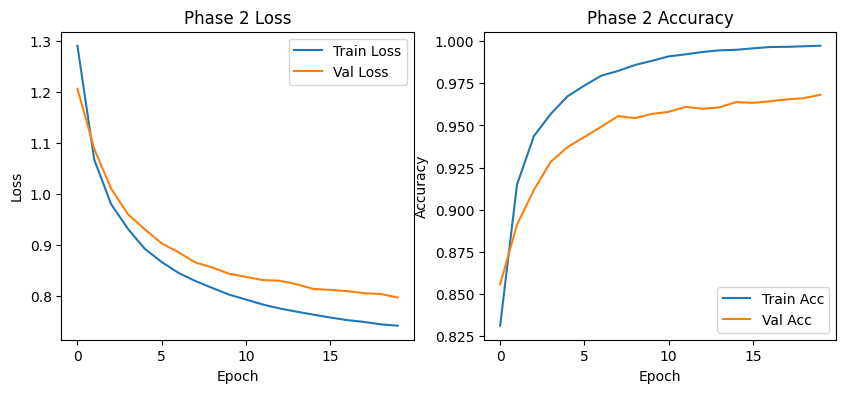

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_acc, n = 0,0,0
    for x,y in tqdm(loader, leave=False):
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*x.size(0)
        total_acc  += (out.argmax(1)==y).sum().item()
        n += x.size(0)
    return total_loss/n, total_acc/n

def evaluate_loss_acc(model, loader, criterion):
    model.eval()
    total_loss, n = 0,0
    preds, trues = [], []
    with torch.no_grad():
        for x,y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out,y)
            total_loss += loss.item() * x.size(0)
            n += x.size(0)
            preds += out.argmax(1).cpu().tolist()
            trues += y.tolist()
    acc = accuracy_score(trues, preds)
    return total_loss/n, acc

for p in mobilenet.features.parameters():
    p.requires_grad = False
optimizer = torch.optim.AdamW(filter(lambda p:p.requires_grad, mobilenet.parameters()), lr=3e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

for epoch in range(10):
    tl, ta = train_one_epoch(mobilenet, train_loader, optimizer, criterion)
    vl, va = evaluate_loss_acc(mobilenet, test_loader, criterion)
    print(f"[P1] Epoch {epoch+1}: loss={tl:.4f}, val_loss={vl:.4f}, acc={ta:.4f}, val_acc={va:.4f}")

for p in mobilenet.features.parameters():
    p.requires_grad = True
optimizer = torch.optim.AdamW(mobilenet.parameters(), lr=1e-5)

history_p2 = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
best_acc, patience, wait = 0, 5, 0

for epoch in range(20):
    tl, ta = train_one_epoch(mobilenet, train_loader, optimizer, criterion)
    vl, va = evaluate_loss_acc(mobilenet, test_loader, criterion)

    history_p2["train_loss"].append(tl)
    history_p2["val_loss"].append(vl)
    history_p2["train_acc"].append(ta)
    history_p2["val_acc"].append(va)

    print(f"[P2] Epoch {epoch+1}: loss={tl:.4f}, val_loss={vl:.4f}, acc={ta:.4f}, val_acc={va:.4f}")

    if va > best_acc:
        best_acc, wait = va, 0
        torch.save(mobilenet.state_dict(), "/kaggle/working/mobilenetv2_test.pth")
    else:
        wait += 1
        if wait >= patience:
            print("⏸ Early stop"); break

print("🎯 Best val acc:", best_acc)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_p2["train_loss"], label="Train Loss")
plt.plot(history_p2["val_loss"], label="Val Loss")
plt.title("Phase 2 Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_p2["train_acc"], label="Train Acc")
plt.plot(history_p2["val_acc"], label="Val Acc")
plt.title("Phase 2 Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend()

plt.show()


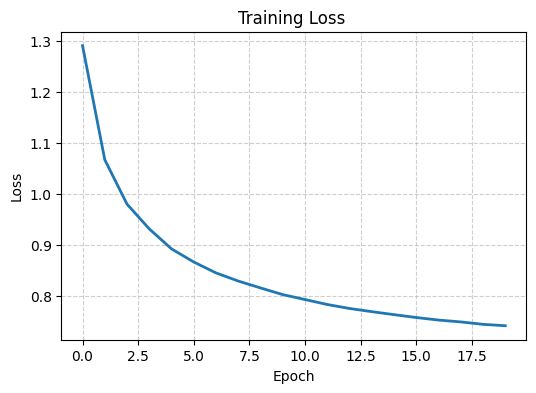

In [ ]:

plt.figure(figsize=(6,4))
plt.plot(history_p2["train_loss"], color='tab:blue', linewidth=2)
plt.title("Training Loss ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mobilenet.load_state_dict(torch.load("/kaggle/working/mobilenetv2_test.pth", map_location=device))
mobilenet.to(device)
mobilenet.eval()

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
total_loss, n = 0, 0
preds, trues = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Evaluating"):
        x, y = x.to(device), y.to(device)
        out = mobilenet(x)
        loss = criterion(out, y)
        total_loss += loss.item() * x.size(0)
        n += x.size(0)
        preds += out.argmax(1).cpu().tolist()
        trues += y.cpu().tolist()

test_loss = total_loss / n
test_acc = accuracy_score(trues, preds)

print(f" Test Loss: {test_loss:.4f}")
print(f" Test Accuracy: {test_acc:.4f}")
print("\n Classification Report:")
print(classification_report(trues, preds))


Evaluating:   0%|          | 0/198 [00:00<?, ?it/s]

 Test Loss: 0.7968
 Test Accuracy: 0.9683

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       0.98      0.98      0.98       450
           4       1.00      0.99      0.99       660
           5       0.96      0.99      0.98       630
           6       1.00      0.99      0.99       150
           7       1.00      1.00      1.00       450
           8       0.99      0.97      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.98      0.99      0.99       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      0.99      1.00       210
          16  

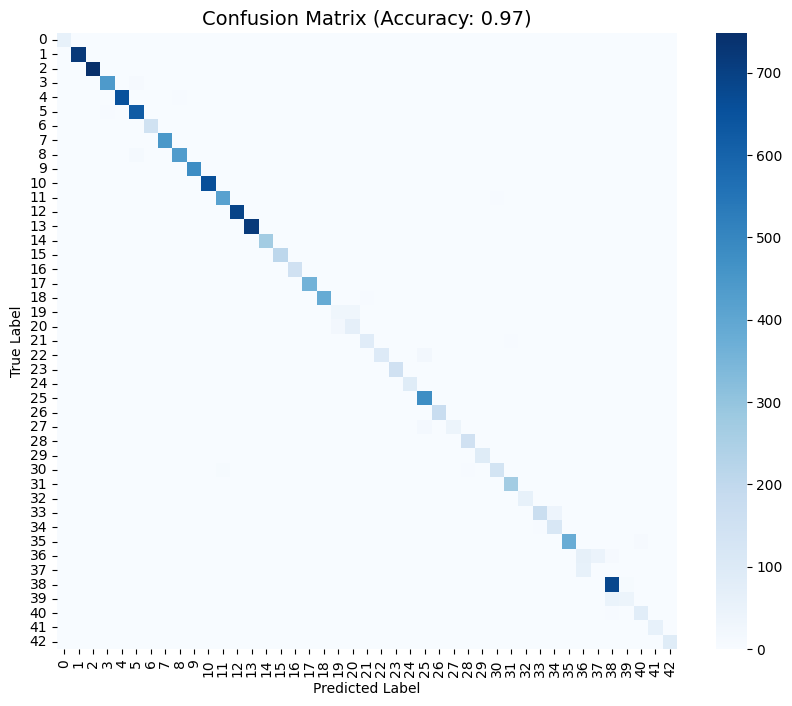

In [ ]:
cm = confusion_matrix(trues, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='Blues', annot=False, fmt='d')
plt.title(f"Confusion Matrix (Accuracy: {test_acc:.2f})", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
